# EM or Hamilton Estimation

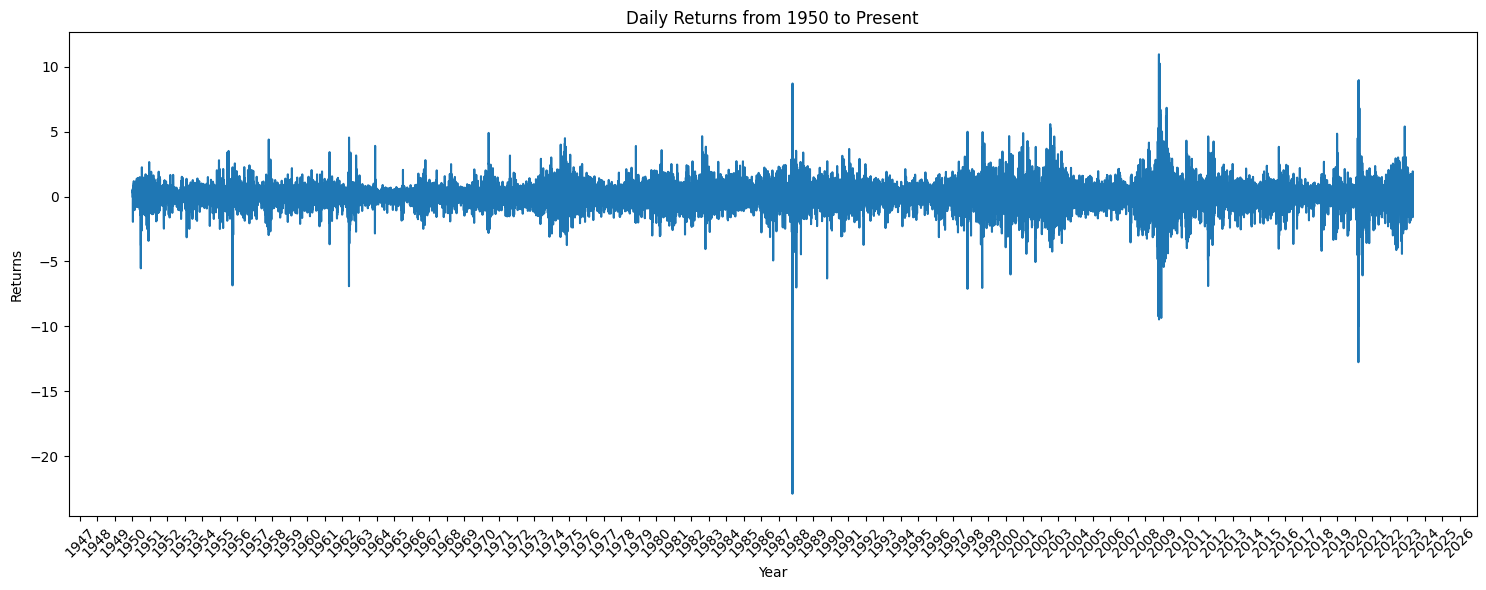

       Unnamed: 0       Date    Return  Pct Returns
0               0 1950-01-04  0.000000     0.000000
1               1 1950-01-05  0.004737     0.473654
2               2 1950-01-06  0.002949     0.294898
3               3 1950-01-09  0.005872     0.587201
4               4 1950-01-10 -0.002932    -0.293163
...           ...        ...       ...          ...
18444       18444 2023-04-24  0.000851     0.085122
18445       18445 2023-04-25 -0.015937    -1.593718
18446       18446 2023-04-26 -0.003849    -0.384858
18447       18447 2023-04-27  0.019377     1.937719
18448       18448 2023-04-28  0.008219     0.821933

[18449 rows x 4 columns]


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import EM
import importlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from hmmlearn import hmm
from arch import arch_model
importlib.reload(EM)

df = pd.read_csv('SP500.csv', sep=';')

df['Date'] = pd.to_datetime(df['Date'])
df['Pct Returns'] = df['Return'] * 100
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Pct Returns'])
plt.xlabel('Year')
plt.ylabel('Returns')
plt.title('Daily Returns from 1950 to Present')

# Setting x-axis to show only the years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print(df)

In [40]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from hmmlearn import hmm


# Assuming 'Return' is the variable you want to model


# Fit an AR(1) model
ar_model = AutoReg(returns, lags=1, old_names=False)
ar_res = ar_model.fit()

# Print the summary of the AR model
print(ar_res.summary())

# Get the residuals from the AR model
ar_resid = ar_res.resid
# garch11 = arch_model(df['Pct Returns'], mean='ARX', lags = 1, vol='Garch', p=1, q=1, dist='t', power=1.0)
# res = garch11.fit(update_freq=10)

# # Step 2: Extract the standardized residuals and conditional volatility
# std_resid = res.resid / res.conditional_volatility
# vol = res.conditional_volatility

# Prepare the residuals for HMM
# Reshape the data for hmmlearn which expects a 2D array
obs = ar_resid.values.reshape(-1, 1)

# Define the number of states for HMM
n_states = 5

# Create and fit the HMM
hmm_model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")
hmm_model.fit(obs)

# Predict the states
hidden_states = hmm_model.predict(obs)

# Output the hidden states
print("Hidden states:")
print(hidden_states)


                            AutoReg Model Results                             
Dep. Variable:            Pct Returns   No. Observations:                18449
Model:                     AutoReg(1)   Log Likelihood              -26152.607
Method:               Conditional MLE   S.D. of innovations              0.999
Date:                Wed, 06 Dec 2023   AIC                          52311.214
Time:                        08:07:31   BIC                          52334.682
Sample:                             1   HQIC                         52318.922
                                18449                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0299      0.007      4.063      0.000       0.015       0.044
Pct Returns.L1    -0.0006      0.007     -0.076      0.940      -0.015       0.014
                                    

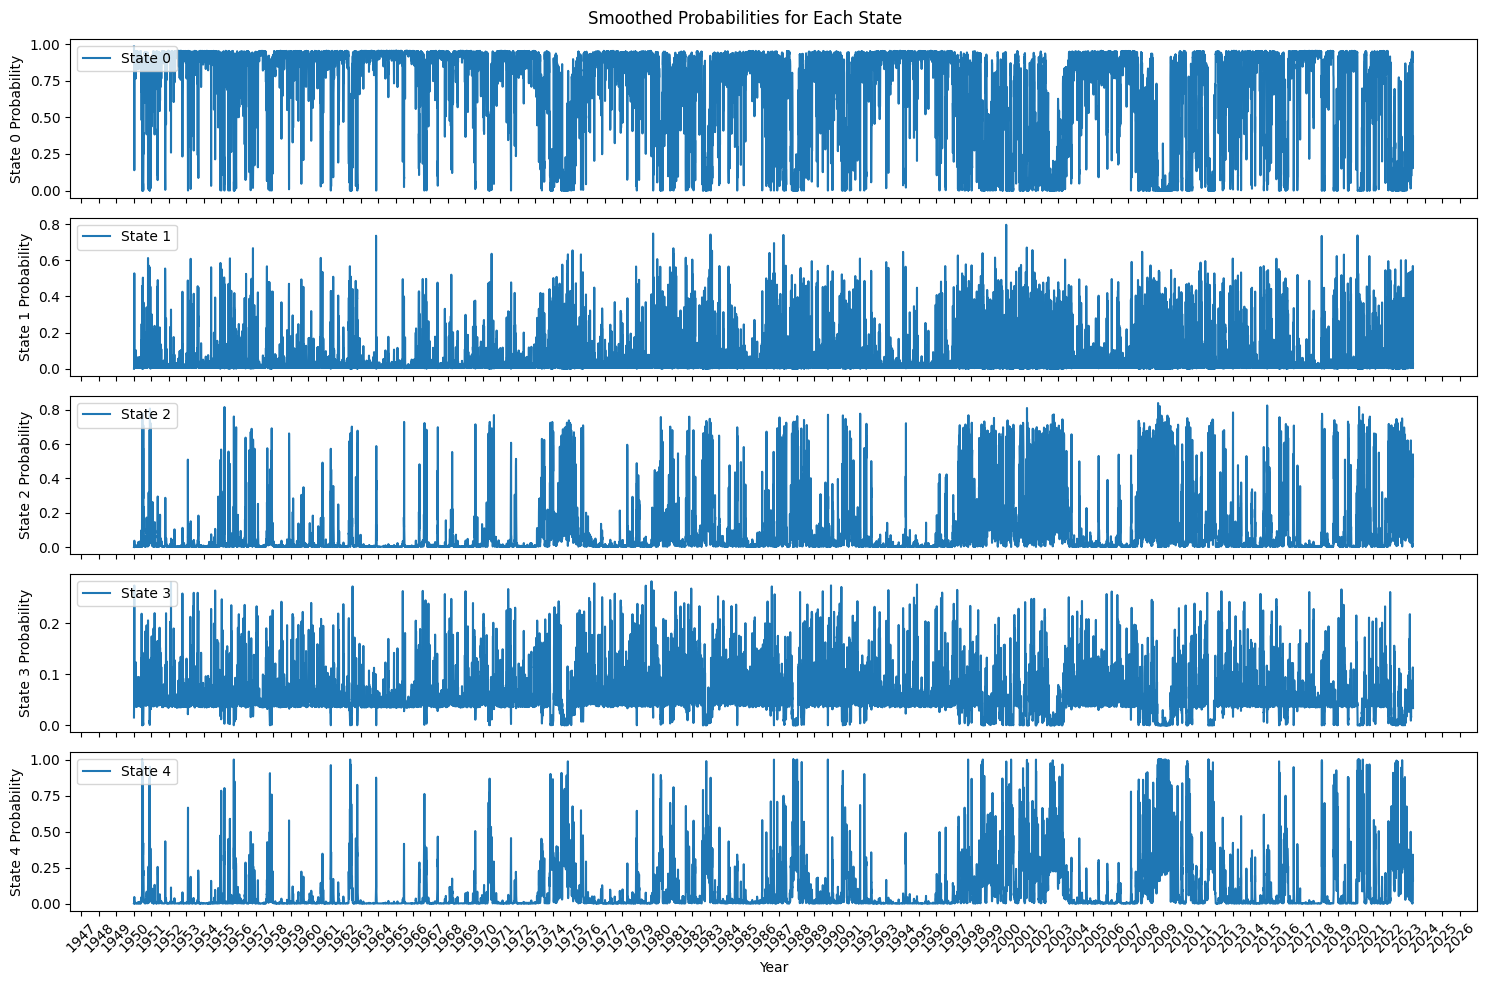

In [41]:
smoothed_probs = hmm_model.predict_proba(obs)
# Align the dates to the observations
# Drop the first date to match the length of the smoothed probabilities
aligned_dates = df['Date'][1:]

# Ensure lengths match
assert len(aligned_dates) == len(smoothed_probs), "Date and probability lengths do not match."

# Create a figure with 3 subplots (one for each state)
fig, axs = plt.subplots(hmm_model.n_components, 1, figsize=(15, 10), sharex=True)

for i, ax in enumerate(axs):
    ax.plot(aligned_dates, smoothed_probs[:, i], label=f"State {i}")
    ax.set_ylabel(f"State {i} Probability")
    ax.legend(loc='upper left')

    # Format x-axis to show only the years
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set common labels and titles
axs[-1].set_xlabel("Year")
plt.suptitle("Smoothed Probabilities for Each State")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


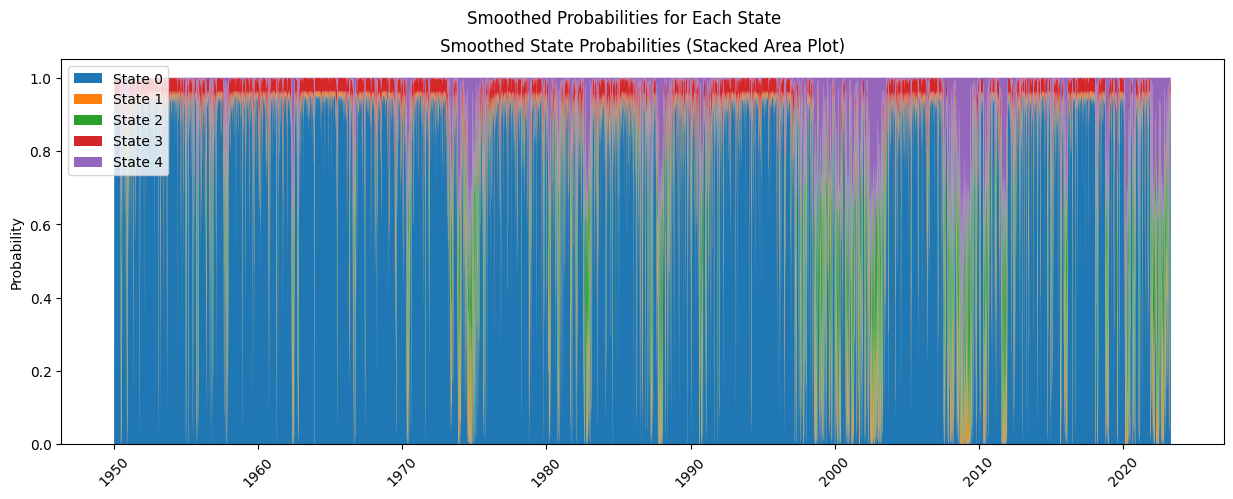

In [42]:
import matplotlib.pyplot as plt

# Assuming you already have your HMM model fitted as 'model'
# and your observations as 'obs'

# Compute smoothed probabilities


# Prepare the time axis (assuming equal intervals)
time = np.arange(len(obs))

# Plot the stacked area chart
plt.figure(figsize=(15, 5))
plt.stackplot(aligned_dates, smoothed_probs.T, labels=[f"State {i}" for i in range(hmm_model.n_components)])
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title("Smoothed State Probabilities (Stacked Area Plot)")
axs[-1].set_xlabel("Year")
plt.suptitle("Smoothed Probabilities for Each State")

plt.xticks(rotation=45)
plt.ylabel("Probability")
plt.legend(loc='upper left')
plt.show()



In [43]:


# ... [previous code] ...

# Drop the first row of the DataFrame to match the length of hidden_states
df_aligned = df.iloc[1:].copy()

# Add the predicted states to the aligned DataFrame
df_aligned['State'] = hidden_states

# Fit a t-distributed GARCH(1,1) model for each state
garch_models = {}
for state in range(hmm_model.n_components):
    # Filter data for the current state
    state_data = df_aligned[df_aligned['State'] == state]['Pct Returns']

    # Check if state_data is not empty
    if len(state_data) > 0:
        # Fit a t-distributed GARCH(1,1) model to this state's data
        garch11 = arch_model(state_data, mean='ARX', lags = 1, vol='Garch', p=1, q=1, dist='t', power=1.0)
        garch_res = garch11.fit(update_freq=10, disp='off')

        # Store the fitted model
        garch_models[state] = garch_res
    else:
        print(f"No data available for State {state}, skipping GARCH model fitting.")

# Output the summary of each model
for state, model in garch_models.items():
    print(f"State {state} t-GARCH(1,1) Model:")
    print(model.summary())
    print("\n")


No data available for State 3, skipping GARCH model fitting.
State 0 t-GARCH(1,1) Model:
                             AR - AVGARCH Model Results                             
Dep. Variable:                  Pct Returns   R-squared:                       0.004
Mean Model:                              AR   Adj. R-squared:                  0.004
Vol Model:                          AVGARCH   Log-Likelihood:               -15108.0
Distribution:      Standardized Student's t   AIC:                           30227.9
Method:                  Maximum Likelihood   BIC:                           30274.0
                                              No. Observations:                15948
Date:                      Wed, Dec 06 2023   Df Residuals:                    15946
Time:                              08:08:10   Df Model:                            2
                                   Mean Model                                  
                    coef    std err          t      P>|t|      95.

/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:1894: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:1895: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/home/august/.venvs/jupyter/lib/python3.11/site-packages/arch/univariate/base.py:1896: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

In [57]:
import numpy as np
import pandas as pd
from arch import arch_model
from hmmlearn.hmm import GaussianHMM

def estimate_garch_hmm(df, max_iters=10, n_states= n_states, convergence_tol=1e-24):
        # Initial GARCH model estimation
    garch_model = arch_model(df['Pct Returns'], mean='ARX', lags=1, vol='Garch', p=1, q=1, dist='t', power=1.0)
    garch_fit = garch_model.fit(disp='off')
    residuals = garch_fit.resid
    residuals = residuals.dropna()
    # Convert residuals to a 2D NumPy array
    residuals_array = residuals.values.reshape(-1, 1)

    # Initialize HMM model
    hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
    print(residuals_array)
    hmm_model.fit(residuals_array)
    states = hmm_model.predict(residuals_array)


    for iteration in range(max_iters):
        print(f"Iteration {iteration+1}")

        # Re-estimate GARCH model based on HMM states
        garch_fit = garch_model.fit(disp='off')
        new_residuals = garch_fit.resid

        # Check for convergence
        if np.max(np.abs(new_residuals - residuals)) < convergence_tol:
            print("Convergence achieved.")
            break

        residuals = new_residuals

        # Re-estimate HMM model
        hmm_model.fit(residuals.reshape(-1, 1))
        states = hmm_model.predict(residuals.reshape(-1, 1))

    return garch_fit, hmm_model

# Example usage
# df = pd.DataFrame(...) # your dataframe with 'Pct Returns'
# 
n_states = 3
garch_fit, hmm_model = estimate_garch_hmm(df)

[[ 0.41857421]
 [ 0.2061991 ]
 [ 0.51118932]
 ...
 [-0.32681699]
 [ 1.90995661]
 [ 0.62931535]]
Iteration 1
Convergence achieved.


In [48]:
import matplotlib.pyplot as plt

# Assuming you already have your HMM model fitted as 'model'
# and your observations as 'obs'

# Compute smoothed probabilities


# Prepare the time axis (assuming equal intervals)
time = np.arange(len(obs))

# Plot the stacked area chart
plt.figure(figsize=(15, 5))
plt.stackplot(aligned_dates, smoothed_probs.T, labels=[f"State {i}" for i in range(hmm_model.n_components)])
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title("Smoothed State Probabilities (Stacked Area Plot)")
axs[-1].set_xlabel("Year")
plt.suptitle("Smoothed Probabilities for Each State")

plt.xticks(rotation=45)
plt.ylabel("Probability")
plt.legend(loc='upper left')
plt.show()


AttributeError: 'Series' object has no attribute 'reshape'

In [20]:
hmm_model.score(obs)

62293.6387666638

In [38]:
# # Assuming 'Return' is the variable you want to model
# returns = df['Pct Returns']

# # Fit an AR(1) model
# ar_model = AutoReg(returns, lags=1, old_names=False)
# ar_res = ar_model.fit()

# # Print the summary of the AR model
# print(ar_res.summary())

# # Get the residuals from the AR model
# ar_resid = ar_res.resid

# # Prepare the residuals for HMM
# # Reshape the data for hmmlearn which expects a 2D array
# obs = ar_resid.values.reshape(-1, 1)

for i in range(1, 60):
    # Define the number of states for HMM
    n_states = i
    
    # Create and fit the HMM
    hmm_model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")
    hmm_model.fit(obs)
    
    # Predict the states
    hidden_states = hmm_model.predict(obs)
    # Transition matrix parameters
    transition_params = n_states * (n_states - 1)
    
    # Emission distribution parameters (assuming Gaussian)
    # Mean and variance for each state and each feature
    emission_params = n_states * 5
    
    # Initial state distribution parameters
    initial_state_params = n_states - 1
    
    # Total number of parameters
    total_params = transition_params + emission_params + initial_state_params

    # Output the hidden states
    print(f"States: {n_states},   Log-Likelihood score:   {hmm_model.score(obs)},     Number of parameters,    {total_params}")

States: 1,   Log-Likelihood score:   -26152.60693845929,     Number of parameters,    5
States: 2,   Log-Likelihood score:   -22881.816927567063,     Number of parameters,    13
States: 3,   Log-Likelihood score:   -22591.65457183457,     Number of parameters,    23
States: 4,   Log-Likelihood score:   -22461.2279680863,     Number of parameters,    35
States: 5,   Log-Likelihood score:   -22439.811449972854,     Number of parameters,    49
States: 6,   Log-Likelihood score:   -22664.494603349696,     Number of parameters,    65
States: 7,   Log-Likelihood score:   -22232.300035026547,     Number of parameters,    83
States: 8,   Log-Likelihood score:   -22320.75323162398,     Number of parameters,    103
States: 9,   Log-Likelihood score:   -22141.424786263146,     Number of parameters,    125
States: 10,   Log-Likelihood score:   -22122.53329320568,     Number of parameters,    149
States: 11,   Log-Likelihood score:   -22605.484238785037,     Number of parameters,    175
States: 12,

In [37]:
from scipy.stats import chi2

# Model details: states, log-likelihoods, and number of parameters
models = [
    {"states": 1, "log_likelihood": -26152.60693845929, "params": 5},
    {"states": 2, "log_likelihood": -22882.596199320946, "params": 13},
    {"states": 3, "log_likelihood": -22773.878817347417, "params": 23},
    {"states": 4, "log_likelihood": -23220.32156184918, "params": 35},
    {"states": 5, "log_likelihood": -22703.879889250642, "params": 49},
    {"states": 6, "log_likelihood": -22234.702798717928, "params": 65},
    {"states": 7, "log_likelihood": -22201.744485968604, "params": 83}
]

# Perform likelihood ratio tests
for i in range(1, len(models)):
    ll_diff = 2 * (models[i]["log_likelihood"] - models[i-1]["log_likelihood"])
    df_diff = models[i]["params"] - models[i-1]["params"]
    p_value = chi2.sf(ll_diff, df_diff)

    print(f"Test {models[i-1]['states']} state vs {models[i]['states']} states: LR = {ll_diff:.2f}, p-value = {p_value:.4f}")

# Note: Lower p-value (< 0.05 typically) suggests the more complex model is significantly better


Test 1 state vs 2 states: LR = 6540.02, p-value = 0.0000
Test 2 state vs 3 states: LR = 217.43, p-value = 0.0000
Test 3 state vs 4 states: LR = -892.89, p-value = 1.0000
Test 4 state vs 5 states: LR = 1032.88, p-value = 0.0000
Test 5 state vs 6 states: LR = 938.35, p-value = 0.0000
Test 6 state vs 7 states: LR = 65.92, p-value = 0.0000
